In [1]:
from __future__ import (
    print_function,
    division
)

import matplotlib.pyplot as plt
import stopwordsiso as swiso
import seaborn as sns
import pandas as pd
import numpy as np
import cleantext
import warnings
import random
import string
import pickle
import spacy
import json
import nltk
import time
import abc
import os 
import re
import sys 
sys.path.append('./src')

from spellchecker import SpellChecker
from stop_words import get_stop_words
from collections import OrderedDict
from nltk.stem import PorterStemmer
from collections import Counter
from nltk.corpus import stopwords
from wordcloud import WordCloud


from textblob import (
    TextBlob,
    Word
)

from typing import (
    Callable,
    Iterable,
    List,
    Union,
    Tuple,
)

from utils import (
    Classifier,
    Pipeline,
    Vocabulary,
    json_print,
    timeit,
    random_seed
)
from supervised import (
    KNeighborsClassifier,
    MultiNominalNaiveBayes,
    BernaulliNaiveBayes
)
from feature import (
    BackwardElimination,
    #mutual_information
)



In [2]:
cols = [
    'date',
    'id',
    'text',
    'query_string',
    'user',
    'sentiment',
]

df = pd.read_csv(
    '../data/training.1600000.processed.noemoticon.csv',
    encoding=  'latin1',
    names = [
        'sentiment',
        'id',
        'date',
        'query_string',
        'user',
        'text'
    ]
)

df = df[cols]

In [3]:
df.head()

,date,id,text,query_string,user,sentiment
0,Mon Apr 06 22:19:45 PDT 2009,1467810369,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",NO_QUERY,_TheSpecialOne_,0
1,Mon Apr 06 22:19:49 PDT 2009,1467810672,is upset that he can't update his Facebook by ...,NO_QUERY,scotthamilton,0
2,Mon Apr 06 22:19:53 PDT 2009,1467810917,@Kenichan I dived many times for the ball. Man...,NO_QUERY,mattycus,0
3,Mon Apr 06 22:19:57 PDT 2009,1467811184,my whole body feels itchy and like its on fire,NO_QUERY,ElleCTF,0
4,Mon Apr 06 22:19:57 PDT 2009,1467811193,"@nationwideclass no, it's not behaving at all....",NO_QUERY,Karoli,0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600000 entries, 0 to 1599999
Data columns (total 6 columns):
 #   Column        Non-Null Count    Dtype 
---  ------        --------------    ----- 
 0   date          1600000 non-null  object
 1   id            1600000 non-null  int64 
 2   text          1600000 non-null  object
 3   query_string  1600000 non-null  object
 4   user          1600000 non-null  object
 5   sentiment     1600000 non-null  int64 
dtypes: int64(2), object(4)
memory usage: 73.2+ MB


In [5]:
df.set_index('id', inplace=True)
df.drop(
    columns= [
        'date', 'query_string'
    ],
    axis=1,
    inplace=True
)

In [6]:
df.head(7)

,text,user,sentiment
id,,,
1467810369,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",_TheSpecialOne_,0
1467810672,is upset that he can't update his Facebook by ...,scotthamilton,0
1467810917,@Kenichan I dived many times for the ball. Man...,mattycus,0
1467811184,my whole body feels itchy and like its on fire,ElleCTF,0
1467811193,"@nationwideclass no, it's not behaving at all....",Karoli,0
1467811372,@Kwesidei not the whole crew,joy_wolf,0
1467811592,Need a hug,mybirch,0


<AxesSubplot:title={'center':'Sentiment Distribution'}, xlabel='[Neg, Pos]'>

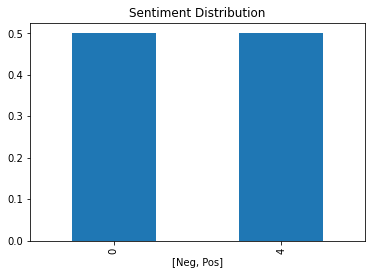

In [7]:
df['sentiment'].value_counts(
    normalize = True
    ).plot.bar(
        title = 'Sentiment Distribution',
        xlabel = ['Neg', 'Pos']
)

In [8]:
print(f"Max length of the tweet {df.text.str.len().max()}")
print(f"Min length of the tweet {df.text.str.len().min()}")
print(f"Average length of the tweet {df.text.str.len().mean()}")
print(f"Median length of the tweet {df.text.str.len().median()}")

Max length of the tweet 374
Min length of the tweet 6
Average length of the tweet 74.09011125
Median length of the tweet 69.0


In [11]:
len_stats = pd.DataFrame(df.text.str.len().describe())
len_stats.col = 'tweet_len_stats'
len_stats 

,text
count,1.600000e+06
mean,7.409011e+01
std,3.644114e+01
min,6.000000e+00
25%,4.400000e+01
50%,6.900000e+01
75%,1.040000e+02
max,3.740000e+02


In [13]:
df['sentiment'] = df['sentiment'].replace(
    {
        4:1
    }
)

df['sentiment'].sample(5)

id
2218569784    0
1792721309    1
1685552740    0
2210705646    0
2194002279    0
Name: sentiment, dtype: int64

In [171]:
class Cleaner:
    def __init__(self, operations = []):
        self.operations = operations

    def __call__(self, text):
        for operation in self.operations:
            text = operation(text)
        return text

def lower_case(text):
    return text.lower()

def remove_mentiones_and_hashtag(text):
    return re.sub('@[^ ]+|#[^ ]+', '', text)

def remove_punctuation(text):
    return text.replace('[^A-Za-z0-9 ]', "")

def remove_punctuations_layer_2(text):
    punct = re.compile(r'[^\w\s]')
    
    return punct.sub(r'',text)

def remove_stop_words(text):
    #stop_words = get_stop_words()
    return " ".join(word for word in text.split() if word not in stop_words)


def remove_emoji(text):
    """ Reference : https://gist.github.com/slowkow/7a7f61f495e3dbb7e3d767f97bd7304b"""
    emoji_pattern = re.compile("["
                        u"\U0001F600-\U0001F64F"  # emoticons
                        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                        u"\U0001F680-\U0001F6FF"  # transport & map symbols
                        u"\U0001F1E0-\U0001F1FF"  # flags 
                        u"\U00002702-\U000027B0"
                        u"\U000024C2-\U0001F251"
                        "]+",
                        flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)


def remove_HTML(text):
    tag = re.compile(r'<.*?>')
    
    return tag.sub(r'',text)

def remove_URL(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    
    return url.sub(r'',text)
    
def get_stop_words_(all_languages:bool = False):
    stop_words_1 = stopwords.words('english')
    stop_words_2 = get_stop_words('english')
    stop_words_3 = list(swiso.stopwords('en'))


    stop_words = stop_words_1 + stop_words_2 + stop_words_3 

    if all_languages:
        stop_words_4 = list(
            swiso.stopwords(
                swiso.langs()
            )
        )
        stop_words = stop_words + stop_words_4

    stop_words = set(stop_words)

    return stop_words

def stemmization(text):
    st = PorterStemmer()
    return " ".join([st.stem(word) for word in text.split()])

def lemmatization(text):
    return " ".join([Word(word).lemmatize() for word in text.split()])

def spell_check(text):
    return str(
        TextBlob(text).correct()
    )
def spell_check_layer_2(text):
    spell = SpellChecker()
    return spell.correction(text)


def spacy_lemmatization(text):
    nlp = spacy.load("en_core_web_sm")
    return " ".join([word.lemma_ for word in nlp(text)])

def final_cleaner(text):
    return cleantext.clean(text, all= True) 

stop_words = get_stop_words_()

In [204]:
%%time
clean_text(
    df.text.iloc[0],
    operations = [
        remove_HTML,
        remove_URL,
        lower_case,
        remove_mentiones_and_hashtag,
        remove_punctuation,
        remove_punctuations_layer_2,
        remove_emoji,
        remove_stop_words,
        #spell_check,
        #spell_check_layer_2,
        stemmization,
        lemmatization,
        #spacy_lemmatization,
        final_cleaner  
    ]
)

CPU times: user 1.3 ms, sys: 592 µs, total: 1.89 ms
Wall time: 1.33 ms


'awww bummer shoulda david carr day'

In [205]:
df['clean_text'] = df['text'].apply(
    Cleaner(
        operations = [
            remove_HTML,
            remove_URL,
            lower_case,
            remove_mentiones_and_hashtag,
            remove_punctuation,
            remove_punctuations_layer_2,
            remove_emoji,
            remove_stop_words,
            #spell_check,
            #spell_check_layer_2,
            stemmization,
            lemmatization,
            #spacy_lemmatization,
            final_cleaner  
        ]
    )
)

df.to_csv('data/cleaned_preprocessed_data.csv')

In [16]:
df = pd.read_csv('../data/cleaned_preprocessed_data.csv')

cols = [
    'id',
    'text',
    'clean_text',
    'user',
    'sentiment',
]

df = df[cols]

df['clean_text'] = df['clean_text'].str.replace(",", '')
df['clean_text'] = df['clean_text'].str.replace(".", '')
df['clean_text'] = df['clean_text'].str.strip()

df.drop(
    ['id'],
    axis = 1,
    inplace = True
)

/var/folders/2s/tzkz7dx17_94s45s202b6n180000gn/T/ipykernel_44603/4026106867.py:14: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df['clean_text'] = df['clean_text'].str.replace(".", '')


In [17]:
neg_tweets = df.loc[df['sentiment']==0]
pos_tweets = df.loc[df['sentiment']==1]

In [18]:
neg_string = neg_tweets['clean_text'].str.cat(sep=' ')
pos_string = pos_tweets['clean_text'].str.cat(sep=' ')

Text(0.5, 1.0, 'Tweets with Negative sentiment')

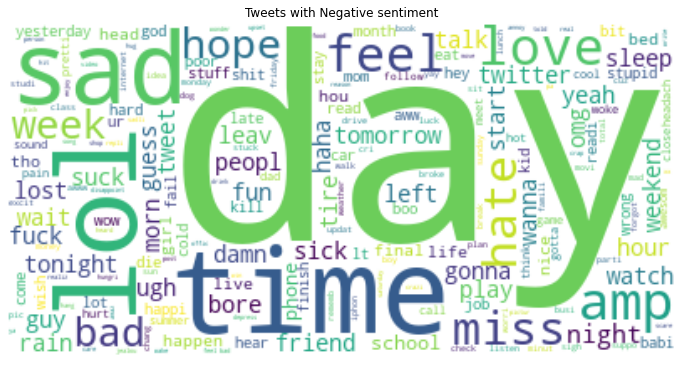

In [19]:
plt.figure(figsize=(12,10))
wordcloud_neg = WordCloud(max_font_size=200, background_color="white").generate(neg_string) 
plt.imshow(wordcloud_neg, interpolation="bilinear")
plt.axis('off')
plt.title("Tweets with Negative sentiment")

Text(0.5, 1.0, 'Tweets with Positive sentiment')

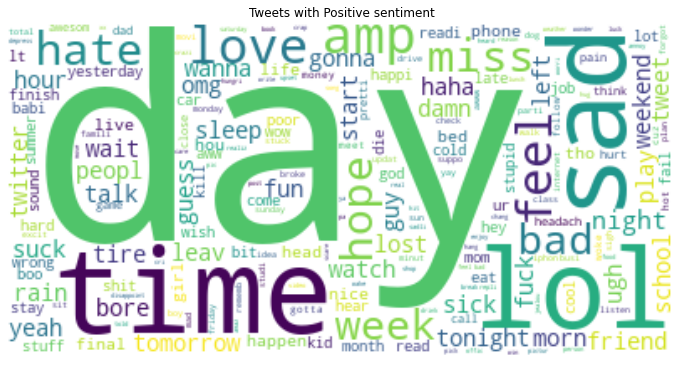

In [22]:
plt.figure(figsize=(12,10))
wordcloud_pos = WordCloud(max_font_size=200, background_color="white").generate(neg_string)
plt.imshow(wordcloud_pos, interpolation="bilinear")
plt.axis('off')
plt.title("Tweets with Positive sentiment")

In [220]:
def remove_unknown_(text):
    s = SpellChecker()
    unknown_words = s.unknown(text.split())
    return " ".join(word for word in text.split() if word not in unknown_words)


In [221]:
df['unknown_removed_cleaned'] = df['clean_text'].apply(remove_unknown_)

In [ ]:
df.to_csv('data/cleaned_preprocessed_unknown_removed_data.csv')